In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install diffusers[torch] transformers
!pip install controlnet_aux
!pip install opencv-python
!pip install matplotlib
!pip install datasets
!pip install -U diffusers
!pip install -U transformers accelerate
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import os

# Function to extract edges from an image
def extract_edges(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Define dataset and output paths
dataset_path = "/content/drive/MyDrive/datafloor"  # Path to your dataset
output_path = "/content/drive/MyDrive/processed_dataset"  # Path to save processed images

# Create the output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Preprocess all images in your dataset
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)
    if os.path.isdir(label_path):
        # Create a subfolder in the output directory for each label
        output_label_path = os.path.join(output_path, label_folder)
        os.makedirs(output_label_path, exist_ok=True)

        # Process each image in the label folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            edges = extract_edges(image_path)
            # Save the processed image
            output_image_path = os.path.join(output_label_path, image_name)
            cv2.imwrite(output_image_path, edges)

print("Dataset preprocessing complete!")

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FloorPlanDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Debug: Print the image folder being used
        print(f"Loading dataset from: {image_folder}")

        for label_folder in os.listdir(image_folder):
            label_path = os.path.join(image_folder, label_folder)
            if os.path.isdir(label_path):
                # Debug: Print the label folder being processed
                print(f"Processing label folder: {label_folder}")
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(label_folder.split("_")[0]))  # Extract label from folder name

        # Debug: Print the total number of images loaded
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import re  # Regular expressions for extracting numbers

class FloorPlanDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Debug: Print the image folder being used
        print(f"Loading dataset from: {image_folder}")

        for label_folder in os.listdir(image_folder):
            label_path = os.path.join(image_folder, label_folder)
            if os.path.isdir(label_path):
                # Debug: Print the label folder being processed
                print(f"Processing label folder: {label_folder}")

                # Extract the numeric part from the folder name (e.g., "3 rooms" -> 3)
                match = re.search(r'\d+', label_folder)  # Find the first number in the folder name
                if match:
                    label = int(match.group())  # Convert the numeric part to an integer
                else:
                    raise ValueError(f"Folder name '{label_folder}' does not contain a valid number.")

                # Process each image in the label folder
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)  # Use the extracted label

        # Debug: Print the total number of images loaded
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
import os

# Path to the original dataset
original_dataset_path = "/content/drive/MyDrive/datafloor"

# List all folders in the original dataset
folders = [f for f in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, f))]
print("Folders in original dataset:", folders)

Folders in original dataset: ['4 rooms', '5 rooms', '3 rooms']


In [11]:
# Path to the processed dataset
processed_dataset_path = "/content/drive/MyDrive/processed_dataset"

# List all folders in the processed dataset
folders = [f for f in os.listdir(processed_dataset_path) if os.path.isdir(os.path.join(processed_dataset_path, f))]
print("Folders in processed dataset:", folders)

Folders in processed dataset: ['4 rooms', '5 rooms', '3 rooms']


In [12]:
import cv2
import numpy as np
from PIL import Image
import os

# Function to extract edges from an image
def extract_edges(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Define dataset and output paths
dataset_path = "/content/drive/MyDrive/datafloor"  # Path to your original dataset
output_path = "/content/drive/MyDrive/processed_dataset"  # Path to save processed images

# Create the output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Preprocess all images in your dataset
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)
    if os.path.isdir(label_path):
        # Create a subfolder in the output directory for each label
        output_label_path = os.path.join(output_path, label_folder)
        os.makedirs(output_label_path, exist_ok=True)

        # Process each image in the label folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            edges = extract_edges(image_path)
            # Save the processed image
            output_image_path = os.path.join(output_label_path, image_name)
            cv2.imwrite(output_image_path, edges)

print("Dataset preprocessing complete!")

Dataset preprocessing complete!


In [13]:
from torchvision import transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Create dataset
dataset = FloorPlanDataset(image_folder="/content/drive/MyDrive/processed_dataset", transform=transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Debug: Print a batch of data
for batch in dataloader:
    images, labels = batch
    print("Batch images shape:", images.shape)
    print("Batch labels:", labels)
    break

Loading dataset from: /content/drive/MyDrive/processed_dataset
Processing label folder: 4 rooms
Processing label folder: 5 rooms
Processing label folder: 3 rooms
Total images loaded: 510
Batch images shape: torch.Size([4, 3, 512, 512])
Batch labels: tensor([3, 5, 4, 5])


In [14]:
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline
import torch

# Load ControlNet model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")

# Load Stable Diffusion model with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
from torch.optim import AdamW
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F

# Load the tokenizer and text encoder for Stable Diffusion
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")

# Define optimizer
optimizer = AdamW(controlnet.parameters(), lr=1e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    controlnet.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        control_images, labels = batch
        control_images = control_images.to("cuda")

        # Zero gradients
        optimizer.zero_grad()

        # Prepare text embeddings with proper padding
        text_inputs = tokenizer(
            [f"{label}-room floor plan" for label in labels],
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_input_ids = text_inputs.input_ids.to("cuda")

        # Get text embeddings
        with torch.no_grad():
            text_embeddings = text_encoder(text_input_ids)[0]

        # Create appropriate noise sample - make sure dimensions match UNet expectations
        # Check the expected channel dimension of your UNet
        batch_size = control_images.shape[0]

        # Most SD models expect 4 channels for latents
        # The spatial dimensions should be 1/8 of the original image size
        # For 512×512 images, latents would be 64×64
        latent_height, latent_width = 64, 64
        noise = torch.randn(
            (batch_size, 4, latent_height, latent_width),
            device="cuda"
        )

        # Generate random timesteps
        timesteps = torch.randint(
            0, 1000, (batch_size,),
            device="cuda"
        ).long()

        # Make sure control images match expected input shape
        # If control_images aren't already transformed to match ControlNet's expected input
        # Add a transformation here if needed

        # Forward pass through ControlNet
        try:
            down_block_res_samples, mid_block_res_sample = controlnet(
                sample=noise,
                timestep=timesteps,
                encoder_hidden_states=text_embeddings,
                controlnet_cond=control_images,
                return_dict=False,
            )

            # Simple loss example (regularize outputs)
            loss = 0
            for res_sample in down_block_res_samples:
                loss += res_sample.pow(2).mean()
            loss += mid_block_res_sample.pow(2).mean()

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        except Exception as e:
            print(f"Error in batch: {e}")
            print(f"Text embeddings shape: {text_embeddings.shape}")
            print(f"Control images shape: {control_images.shape}")
            print(f"Noise shape: {noise.shape}")
            # Skip problematic batch
            continue

    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1} Loss: {avg_epoch_loss}")

# Save the fine-tuned model
controlnet.save_pretrained("/content/drive/MyDrive/fine_tuned_controlnet")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epoch 1/3


  0%|          | 0/128 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

  1%|          | 1/128 [00:03<06:50,  3.23s/it]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 2/128 [00:05<05:10,  2.47s/it]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 3/128 [00:05<03:06,  1.50s/it]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  4%|▍         | 5/128 [00:05<01:24,  1.46it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▌         | 7/128 [00:06<00:45,  2.63it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  7%|▋         | 9/128 [00:06<00:30,  3.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▊         | 11/128 [00:06<00:21,  5.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 10%|█         | 13/128 [00:06<00:18,  6.17it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▏        | 15/128 [00:07<00:16,  6.73it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 13%|█▎        | 17/128 [00:07<00:16,  6.88it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 15%|█▍        | 19/128 [00:07<00:14,  7.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▋        | 21/128 [00:07<00:13,  7.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 18%|█▊        | 23/128 [00:08<00:12,  8.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|█▉        | 25/128 [00:08<00:12,  8.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 21%|██        | 27/128 [00:08<00:12,  8.30it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 29/128 [00:08<00:11,  8.41it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 24%|██▍       | 31/128 [00:09<00:12,  8.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 26%|██▌       | 33/128 [00:09<00:12,  7.85it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 35/128 [00:09<00:12,  7.35it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 29%|██▉       | 37/128 [00:09<00:11,  7.90it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|███       | 39/128 [00:10<00:11,  7.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 32%|███▏      | 41/128 [00:10<00:11,  7.66it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▎      | 43/128 [00:10<00:10,  8.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 35%|███▌      | 45/128 [00:11<00:11,  7.45it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 36%|███▌      | 46/128 [00:11<00:10,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 49/128 [00:11<00:10,  7.57it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 40%|███▉      | 51/128 [00:11<00:11,  6.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████▏     | 53/128 [00:12<00:10,  7.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 42%|████▏     | 54/128 [00:12<00:09,  7.71it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 43%|████▎     | 55/128 [00:12<00:11,  6.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 44%|████▍     | 56/128 [00:12<00:12,  5.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▌     | 58/128 [00:13<00:12,  5.69it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 46%|████▌     | 59/128 [00:13<00:11,  5.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 47%|████▋     | 60/128 [00:13<00:13,  5.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 61/128 [00:13<00:13,  4.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 49%|████▉     | 63/128 [00:14<00:13,  4.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 51%|█████     | 65/128 [00:14<00:12,  5.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 67/128 [00:14<00:11,  5.44it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 53%|█████▎    | 68/128 [00:15<00:11,  5.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▍    | 70/128 [00:15<00:11,  5.19it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 56%|█████▋    | 72/128 [00:15<00:09,  5.69it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 58%|█████▊    | 74/128 [00:15<00:08,  6.53it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▉    | 76/128 [00:16<00:07,  7.02it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 61%|██████    | 78/128 [00:16<00:06,  7.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▎   | 80/128 [00:16<00:06,  7.66it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 64%|██████▍   | 82/128 [00:16<00:05,  7.88it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▌   | 84/128 [00:17<00:05,  7.65it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 67%|██████▋   | 86/128 [00:17<00:05,  8.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 69%|██████▉   | 88/128 [00:17<00:05,  7.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|███████   | 90/128 [00:18<00:04,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 72%|███████▏  | 92/128 [00:18<00:04,  7.22it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 94/128 [00:18<00:04,  7.17it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 75%|███████▌  | 96/128 [00:18<00:04,  7.67it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 98/128 [00:19<00:04,  7.42it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 78%|███████▊  | 100/128 [00:19<00:03,  7.58it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|███████▉  | 102/128 [00:19<00:03,  8.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 81%|████████▏ | 104/128 [00:19<00:03,  7.66it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 83%|████████▎ | 106/128 [00:20<00:02,  7.77it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▍ | 108/128 [00:20<00:02,  7.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 86%|████████▌ | 110/128 [00:20<00:02,  8.19it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 112/128 [00:20<00:01,  8.05it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 89%|████████▉ | 114/128 [00:21<00:01,  7.37it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████ | 116/128 [00:21<00:01,  7.28it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 92%|█████████▏| 118/128 [00:21<00:01,  7.56it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 94%|█████████▍| 120/128 [00:21<00:01,  7.22it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▌| 122/128 [00:22<00:00,  7.42it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 97%|█████████▋| 124/128 [00:22<00:00,  7.94it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 126/128 [00:22<00:00,  8.03it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:22<00:00,  5.58it/s]


Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 1 Loss: 0.0
Epoch 2/3


  2%|▏         | 2/128 [00:00<00:14,  9.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  3%|▎         | 4/128 [00:00<00:13,  9.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▍         | 6/128 [00:00<00:14,  8.66it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  6%|▋         | 8/128 [00:00<00:14,  8.52it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  8%|▊         | 10/128 [00:01<00:14,  8.38it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▉         | 12/128 [00:01<00:13,  8.41it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 11%|█         | 14/128 [00:01<00:13,  8.70it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▎        | 16/128 [00:01<00:13,  8.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 14%|█▍        | 18/128 [00:02<00:13,  7.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▌        | 20/128 [00:02<00:12,  8.47it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 17%|█▋        | 22/128 [00:02<00:12,  8.25it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 19%|█▉        | 24/128 [00:02<00:13,  7.88it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|█▉        | 25/128 [00:03<00:17,  5.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|██        | 26/128 [00:03<00:18,  5.56it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 22%|██▏       | 28/128 [00:03<00:18,  5.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 30/128 [00:04<00:18,  5.21it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 24%|██▍       | 31/128 [00:04<00:17,  5.51it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 26%|██▌       | 33/128 [00:04<00:17,  5.55it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 35/128 [00:05<00:17,  5.39it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 29%|██▉       | 37/128 [00:05<00:16,  5.40it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|███       | 39/128 [00:05<00:15,  5.79it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 32%|███▏      | 41/128 [00:06<00:14,  5.82it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▎      | 43/128 [00:06<00:13,  6.13it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 35%|███▌      | 45/128 [00:06<00:11,  6.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 37%|███▋      | 47/128 [00:06<00:11,  6.77it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 49/128 [00:07<00:10,  7.40it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 40%|███▉      | 51/128 [00:07<00:09,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████▏     | 53/128 [00:07<00:09,  8.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 43%|████▎     | 55/128 [00:08<00:09,  7.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▍     | 57/128 [00:08<00:09,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▌     | 58/128 [00:08<00:08,  7.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 47%|████▋     | 60/128 [00:08<00:08,  8.06it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 49%|████▉     | 63/128 [00:08<00:07,  8.67it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 51%|█████     | 65/128 [00:09<00:07,  8.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 67/128 [00:09<00:07,  8.39it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 54%|█████▍    | 69/128 [00:09<00:07,  8.42it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▌    | 71/128 [00:09<00:07,  7.92it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 57%|█████▋    | 73/128 [00:10<00:07,  7.38it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▊    | 75/128 [00:10<00:07,  7.28it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 60%|██████    | 77/128 [00:10<00:07,  7.11it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▏   | 79/128 [00:11<00:06,  7.55it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 64%|██████▍   | 82/128 [00:11<00:05,  8.87it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▌   | 84/128 [00:11<00:05,  8.52it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 67%|██████▋   | 86/128 [00:11<00:04,  8.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 69%|██████▉   | 88/128 [00:12<00:04,  8.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|███████   | 90/128 [00:12<00:04,  8.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 72%|███████▏  | 92/128 [00:12<00:04,  8.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 94/128 [00:12<00:04,  8.03it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 75%|███████▌  | 96/128 [00:13<00:03,  8.18it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 98/128 [00:13<00:03,  8.22it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 78%|███████▊  | 100/128 [00:13<00:03,  7.47it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|███████▉  | 102/128 [00:13<00:03,  7.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 81%|████████▏ | 104/128 [00:14<00:03,  7.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 83%|████████▎ | 106/128 [00:14<00:02,  8.02it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▍ | 108/128 [00:14<00:02,  7.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 86%|████████▌ | 110/128 [00:14<00:02,  7.52it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 112/128 [00:15<00:02,  7.31it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 113/128 [00:15<00:02,  7.41it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████ | 116/128 [00:15<00:01,  8.13it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 92%|█████████▏| 118/128 [00:15<00:01,  8.01it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 94%|█████████▍| 120/128 [00:16<00:00,  8.30it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▌| 122/128 [00:16<00:00,  7.41it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 97%|█████████▋| 124/128 [00:16<00:00,  6.35it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 126/128 [00:17<00:00,  5.43it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:17<00:00,  7.32it/s]


Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 2 Loss: 0.0
Epoch 3/3


  2%|▏         | 2/128 [00:00<00:23,  5.31it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 3/128 [00:00<00:23,  5.25it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  4%|▍         | 5/128 [00:00<00:23,  5.17it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▌         | 7/128 [00:01<00:22,  5.44it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  7%|▋         | 9/128 [00:01<00:20,  5.71it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▊         | 11/128 [00:02<00:21,  5.55it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 10%|█         | 13/128 [00:02<00:21,  5.33it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▎        | 16/128 [00:02<00:14,  7.52it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 14%|█▍        | 18/128 [00:02<00:13,  8.02it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▌        | 20/128 [00:03<00:14,  7.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 17%|█▋        | 22/128 [00:03<00:13,  7.94it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|█▉        | 25/128 [00:03<00:11,  9.01it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 21%|██        | 27/128 [00:04<00:11,  8.75it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 29/128 [00:04<00:12,  7.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 24%|██▍       | 31/128 [00:04<00:12,  7.99it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 26%|██▌       | 33/128 [00:04<00:11,  8.35it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 35/128 [00:05<00:11,  8.41it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 29%|██▉       | 37/128 [00:05<00:12,  7.57it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|███       | 39/128 [00:05<00:11,  7.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 32%|███▏      | 41/128 [00:05<00:10,  8.26it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▎      | 43/128 [00:06<00:11,  7.37it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 35%|███▌      | 45/128 [00:06<00:11,  7.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 37%|███▋      | 47/128 [00:06<00:10,  7.82it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 49/128 [00:06<00:09,  8.32it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 40%|███▉      | 51/128 [00:07<00:08,  8.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████▏     | 53/128 [00:07<00:09,  7.92it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 43%|████▎     | 55/128 [00:07<00:09,  7.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▍     | 57/128 [00:07<00:09,  7.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 46%|████▌     | 59/128 [00:08<00:09,  7.53it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 61/128 [00:08<00:08,  8.11it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 49%|████▉     | 63/128 [00:08<00:07,  8.26it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 51%|█████     | 65/128 [00:08<00:08,  7.77it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 67/128 [00:09<00:07,  7.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 54%|█████▍    | 69/128 [00:09<00:07,  7.62it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▌    | 71/128 [00:09<00:08,  7.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 57%|█████▋    | 73/128 [00:09<00:07,  7.39it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▊    | 75/128 [00:10<00:06,  7.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 60%|██████    | 77/128 [00:10<00:06,  8.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▏   | 79/128 [00:10<00:06,  7.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 63%|██████▎   | 81/128 [00:10<00:05,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 65%|██████▍   | 83/128 [00:11<00:06,  6.76it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▋   | 85/128 [00:11<00:05,  7.29it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 68%|██████▊   | 87/128 [00:11<00:05,  7.18it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|██████▉   | 89/128 [00:12<00:05,  7.63it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 71%|███████   | 91/128 [00:12<00:04,  8.10it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 93/128 [00:12<00:05,  6.47it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 74%|███████▍  | 95/128 [00:13<00:05,  5.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 76%|███████▌  | 97/128 [00:13<00:05,  5.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 99/128 [00:13<00:05,  5.43it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 79%|███████▉  | 101/128 [00:14<00:04,  6.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|████████  | 103/128 [00:14<00:04,  5.87it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 82%|████████▏ | 105/128 [00:14<00:04,  5.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▎ | 107/128 [00:15<00:03,  5.66it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 85%|████████▌ | 109/128 [00:15<00:03,  5.68it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 87%|████████▋ | 111/128 [00:15<00:02,  5.98it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 113/128 [00:16<00:02,  7.43it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 90%|████████▉ | 115/128 [00:16<00:01,  7.87it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████▏| 117/128 [00:16<00:01,  7.57it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 93%|█████████▎| 119/128 [00:16<00:01,  7.75it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▍| 121/128 [00:17<00:00,  8.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 96%|█████████▌| 123/128 [00:17<00:00,  7.80it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 125/128 [00:17<00:00,  7.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 99%|█████████▉| 127/128 [00:17<00:00,  7.70it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:17<00:00,  7.11it/s]


Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 3 Loss: 0.0


In [16]:
# Load the fine-tuned ControlNet model in float32 (default)
fine_tuned_controlnet = ControlNetModel.from_pretrained(
    "/content/drive/MyDrive/fine_tuned_controlnet"
).to("cuda")

# Load Stable Diffusion with the fine-tuned ControlNet in float32
fine_tuned_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=fine_tuned_controlnet,
    # Remove torch_dtype parameter to use float32
).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:

# Generate a floor plan
prompt = "Generate a 3 bedroom floor plan"
control_image = Image.open("/content/drive/MyDrive/processed_dataset/3 rooms/Cat10_1.jpg")
control_image = control_image.resize((512, 512))
output_image = fine_tuned_pipe(prompt, control_image, num_inference_steps=50).images[0]

# Display the generated image
output_image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

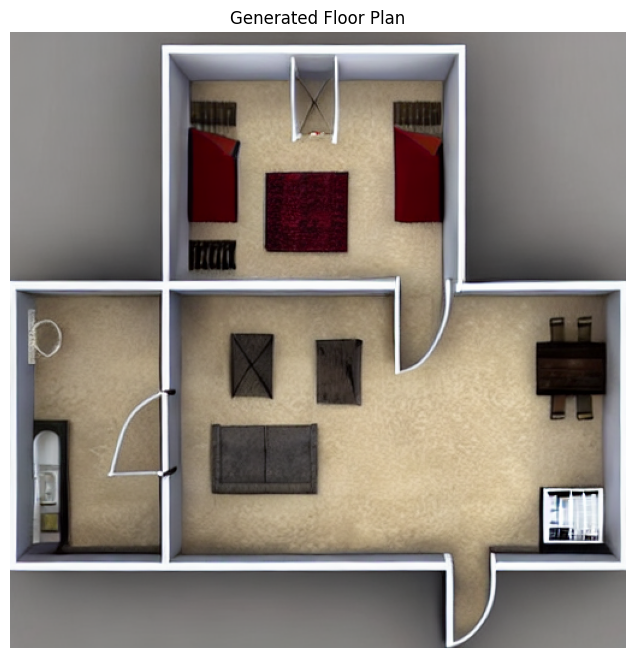

In [18]:
import matplotlib.pyplot as plt
# Display the generated image inline using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.axis("off")
plt.title("Generated Floor Plan")
plt.show()